In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import pickle
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Input, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical

from imgaug import augmenters as iaa
from datetime import datetime

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# %load keras_utils.py
import keras
import numpy as np
import skimage.io as io

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, center_IDs=None, batch_size=32, dim=(256,256,3), shuffle=True, img_preprocess=None, img_aug = None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.center_IDs = center_IDs
        self.n_classes = labels.shape[1]
        self.shuffle = shuffle
        self.on_epoch_end()
        self.indexes = list(range(0, len(self.list_IDs)))
        self.img_aug = img_aug
        self.img_preprocess = img_preprocess

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size, len(self.list_IDs))]
        
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size, self.n_classes), dtype=int)
        M = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(indexes):

            # Store sample
            X[i,] = io.imread(self.list_IDs[ID]).astype(float)
            
            # Store class
            Y[i,] = self.labels[ID]
        
        if self.img_aug is not None:
            X = self.img_aug.augment_images(X.astype(np.uint8))
        
        X = self.__data_preprocess(X.astype(float))
        
        if self.center_IDs is None:
            return X, Y
        else:
            for i, ID in enumerate(indexes):
                M[i] = self.center_IDs[ID]
            return [X,M], [Y,M]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_preprocess(self, img):
        if self.img_preprocess is None:
            processed_img = img/255.0
        else:
            processed_img = self.img_preprocess(img)
        return processed_img        


In [132]:
FLAG_savedir = '/home/put_data/moth/metadata/5_fold/'
FLAG_sfold = 5

idx_fold = 4

FLAG_hidden = 1024
FLAG_dropout = 0.0
FLAG_base_model = 'ResNet50'
FLAG_batch_size = 32

In [133]:
X = pd.read_csv('/home/put_data/moth/metadata/1121_updated_metadata_flickr_summary_used_final.csv',index_col=0)

In [134]:
X.head()

,Number,Family,Genus,Species,Latitude,Longititude,Alt,date,img_path,Filename,...,Alt_Q75,Alt_Q80,Alt_Q85,Alt_Q90,Alt_Q95,Alt_Q100,Alt_mean,Alt_class,srad,tavg
0,B29-20131018-031,Nolidae,Characoma,Characoma glaucopasta,23.965840,121.493076,168.0,20131018.0,/home/dirl/Desktop/moth/data/flickr/B29-201310...,B29-20131018-031.jpg,...,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,669.333333,1.0,14548.0,23.500000
1,A46-20150128-137,Nolidae,Characoma,Characoma glaucopasta,23.266046,120.825008,1004.0,20150128.0,/home/dirl/Desktop/moth/data/flickr/A46-201501...,A46-20150128-137.jpg,...,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,669.333333,1.0,11739.0,12.000000
2,A46-20160223-076,Nolidae,Characoma,Characoma glaucopasta,23.266046,120.825008,1004.0,20160223.0,/home/dirl/Desktop/moth/data/flickr/A46-201602...,A46-20160223-076.jpg,...,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,669.333333,1.0,13368.0,13.200000
3,A32-20110927-045,Geometridae,Fascellina,Fascellina chromataria,24.273494,120.948004,1000.0,20110927.0,/home/dirl/Desktop/moth/data/flickr/A32-201109...,A32-20110927-045.jpg,...,670.0,750.0,1000.0,1041.0,1427.0,2287.0,544.849315,1.0,17712.0,21.200001
4,A32-20120523-087,Geometridae,Fascellina,Fascellina chromataria,24.273494,120.948004,1000.0,20120523.0,/home/dirl/Desktop/moth/data/flickr/A32-201205...,A32-20120523-087.jpg,...,670.0,750.0,1000.0,1041.0,1427.0,2287.0,544.849315,1.0,17509.0,19.200001


In [136]:
with open(os.path.join('/home/put_data/moth/metadata/1121_Y_mean_dict.pickle'), 'rb') as handle:
    Y_dict = pickle.load(handle)

In [137]:
FLAG_model_save = '/home/put_data/moth/code/cmchang/regression/fullcrop_dp{0}_newaug-rmhue+old_species_keras_resnet_fold_{1}_{2}'.format(int(FLAG_dropout*100),                                                                                                                                datetime.now().strftime('%Y%m%d'), 
                                                                                                                               idx_fold)
if not os.path.exists(FLAG_model_save):
    os.makedirs(FLAG_model_save)
print('directory: {}'.format(FLAG_model_save))

make a directory: /home/put_data/moth/code/cmchang/regression/fullcrop_dp0_newaug-rmhue+old_species_keras_resnet_fold_20181122_4


In [138]:
X['img_rmbg_path'] = X.Number.apply(lambda x: '/home/put_data/moth/data/whole_crop/'+str(x)+'.png')

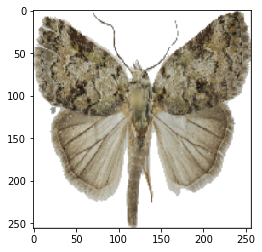

In [139]:
plt.imshow(io.imread(X.img_rmbg_path[0]))

In [141]:
sel = list()
for i in range(X.shape[0]):
    if os.path.exists(X['img_rmbg_path'][i]):
        sel.append(True)
    else:
        sel.append(False)

In [142]:
X = X[sel]

In [143]:
Xtrain = X[(X.Species.duplicated() == False)]
Xsplit = X[(X.Species.duplicated() == True)]

print("Unique: {0}; Duplicate: {1}".format(Xtrain.shape, Xsplit.shape))

Unique: (1951, 36); Duplicate: (21243, 36)


In [144]:
from sklearn.model_selection import train_test_split
Xmerge, Xtest = train_test_split(Xsplit, test_size = 0.2, random_state=0)
Xtrain = pd.concat([Xtrain, Xmerge])

In [145]:
Ytrain = np.vstack(Xtrain['Species'].apply(lambda x: Y_dict[x]))
Ytest = np.vstack(Xtest['Species'].apply(lambda x:  Y_dict[x]))

print('Xtrain.shape: {0}, Ytrain.shape: {1}'.format(Xtrain.shape, Ytrain.shape))
print('Xtest.shape: {0}, Ytest.shape: {1}'.format(Xtest.shape, Ytest.shape))

Xtrain.shape: (18945, 36), Ytrain.shape: (18945, 1)
Xtest.shape: (4249, 36), Ytest.shape: (4249, 1)


In [146]:
Xtrain.to_csv(os.path.join(FLAG_model_save,'train.csv'), index=False)

In [147]:
Xtest.to_csv(os.path.join(FLAG_model_save,'test.csv'), index=False)

In [148]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

augseq = iaa.Sequential([
    iaa.Fliplr(0.5)
    ,sometimes(iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30), # rotate by -45 to +45 degrees
            cval=255 # if mode is constant, use a cval between 0 and 255
        ))
])


In [149]:
# Parameters
input_shape = (256, 256, 3)
n_classes = Ytest.shape[1]
batch_size = FLAG_batch_size
isCenterloss = False

In [150]:
from keras.regularizers import l2

In [151]:
img_input = Input(shape=input_shape)
extractor = ResNet50(input_tensor=img_input, include_top=False, weights='imagenet', pooling='avg')
x1 = Dense(FLAG_hidden)(extractor.output)
x1 = BatchNormalization()(x1)
x1 = Activation(activation='relu')(x1)
output = Dense(n_classes, activation='linear', name='output_layer')(x1)

In [152]:
train_params = {'dim': input_shape,
          'batch_size': FLAG_batch_size,
          'shuffle': True,
          'img_aug': augseq,
          'img_preprocess':  tf.contrib.keras.applications.resnet50.preprocess_input}

valid_params = {'dim': input_shape,
          'batch_size': FLAG_batch_size,
          'shuffle': False,
          'img_aug': None,
          'img_preprocess':  tf.contrib.keras.applications.resnet50.preprocess_input}


model = Model(inputs=img_input, outputs=output)
model.compile(optimizer=Adam(lr=5e-5, beta_1=0.5), 
              loss="mean_squared_error")
# Generators
training_generator   = DataGenerator(list_IDs = list(Xtrain['img_rmbg_path']), labels = Ytrain, center_IDs = None, **train_params)
validation_generator = DataGenerator(list_IDs = list(Xtest['img_rmbg_path']), labels = Ytest, center_IDs = None, **valid_params)


In [153]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D) (None, 262, 262, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 128, 128, 64)  9472        zero_padding2d_2[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 128, 128, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [154]:
csv_logger = keras.callbacks.CSVLogger(os.path.join(FLAG_model_save, 'training.log'))
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(FLAG_model_save, 'model.h5'), 
                                             monitor='val_loss', 
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='min',
                                             period=1)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',patience=20,min_delta=0.01)

In [155]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                   validation_data=validation_generator,
                   steps_per_epoch=Xtrain.shape[0]/FLAG_batch_size, 
                   validation_steps=Xtest.shape[0]/FLAG_batch_size,
                   epochs=200,
                   callbacks=[csv_logger, checkpoint, earlystop])

Epoch 1/200
593/592 [==============================] - 305s - loss: 1020976.4823 - val_loss: 928932.1382
Epoch 2/200
593/592 [==============================] - 261s - loss: 988873.8030 - val_loss: 886246.2737
Epoch 3/200
593/592 [==============================] - 263s - loss: 946230.9317 - val_loss: 827497.6471
Epoch 4/200
593/592 [==============================] - 262s - loss: 894498.4770 - val_loss: 794859.0489
Epoch 5/200
593/592 [==============================] - 260s - loss: 830308.2893 - val_loss: 725501.3689
Epoch 6/200
593/592 [==============================] - 261s - loss: 768687.0224 - val_loss: 651158.4041
Epoch 7/200
593/592 [==============================] - 260s - loss: 707308.0505 - val_loss: 597306.5672
Epoch 8/200
593/592 [==============================] - 263s - loss: 646440.5412 - val_loss: 664547.7185
Epoch 9/200
593/592 [==============================] - 262s - loss: 586138.8162 - val_loss: 591501.2077
Epoch 10/200
593/592 [==============================] - 261s - 

593/592 [==============================] - 260s - loss: 7764.6788 - val_loss: 43148.2049
Epoch 58/200
593/592 [==============================] - 258s - loss: 9808.2740 - val_loss: 43812.1931
Epoch 59/200
593/592 [==============================] - 258s - loss: 8489.6580 - val_loss: 44746.5568
Epoch 60/200
593/592 [==============================] - 258s - loss: 8235.3970 - val_loss: 47778.0208
Epoch 61/200
593/592 [==============================] - 258s - loss: 8053.8681 - val_loss: 60411.1867
Epoch 62/200
593/592 [==============================] - 259s - loss: 8273.2831 - val_loss: 57311.5599
Epoch 63/200
593/592 [==============================] - 259s - loss: 8009.3371 - val_loss: 49871.9791
Epoch 64/200
593/592 [==============================] - 258s - loss: 9364.5472 - val_loss: 41693.3863
Epoch 65/200
593/592 [==============================] - 258s - loss: 7688.9906 - val_loss: 49272.2539
Epoch 66/200
593/592 [==============================] - 259s - loss: 7439.9731 - val_loss: 4398

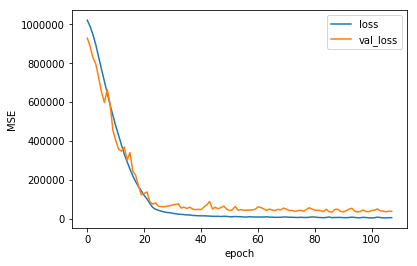

In [156]:
loss = pd.read_table(csv_logger.filename, delimiter=',')

plt.plot(loss.epoch, loss.loss, label='loss')
plt.plot(loss.epoch, loss.val_loss, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.savefig(os.path.join(FLAG_model_save, 'loss.png'))

In [157]:
best_epoch = np.argmin(loss.val_loss)

/home/cmchang/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [158]:
header = 'model_save,base_model,batch_size,hidden,dropout,epoch,loss,val_loss\n'
row = '{0},{1},{2},{3},{4},{5},{6:.4f},{7:.4f}\n'.format(FLAG_model_save, 
                           FLAG_base_model,
                          FLAG_batch_size,
                          FLAG_hidden,
                          FLAG_dropout,
                          best_epoch,
                           loss.iloc[best_epoch]['loss'],
                           loss.iloc[best_epoch]['val_loss'])

In [159]:
if os.path.exists('result_summary.csv'):
    with open('result_summary.csv','a') as myfile:
        myfile.write(row)
else:
    with open('result_summary.csv','w') as myfile:
        myfile.write(header)
        myfile.write(row)

### evaluation over validation dataset

In [160]:
from keras.models import load_model
model = load_model(os.path.join(FLAG_model_save,'model.h5'))

In [161]:
TestImg = list()
for i in range(Xtest.shape[0]):
    img = io.imread(list(Xtest['img_rmbg_path'])[i])
    TestImg.append(img)
TestImg = np.stack(TestImg)

TestInput = preprocess_input(TestImg.astype(float))

In [162]:
Pred = model.predict(TestInput)

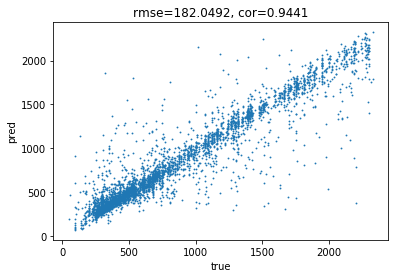

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

plt.scatter(Ytest, Pred, s=0.7)
plt.xlabel('true')
plt.ylabel('pred')
plt.title('rmse={0:.4f}, cor={1:.4f}'.format(np.sqrt(mean_squared_error(y_true=Ytest, y_pred=Pred)),
                                     pearsonr(Ytest, Pred)[0][0]))
plt.savefig(os.path.join(FLAG_model_save, 'scatter_per_img.png'))

In [164]:
result = pd.DataFrame({'Species':Xtest.Species,
              'pred':Pred.reshape(-1),
              'true':Ytest.reshape(-1)})

In [165]:
result.to_csv(os.path.join(FLAG_model_save, 'predictions.csv'), index=False)

### by species

In [166]:
Xtest = Xtest.reset_index()
Xtest.drop(columns='index', inplace=True)

Ytest = np.vstack(Xtest['Species'].apply(lambda x: Y_dict[x]))

In [167]:
df_species_group = Xtest.groupby('Species').apply(
    lambda g: pd.Series({
        'indices': g.index.tolist(),
        # 'Alt_class': g['Alt_class'].unique().tolist()[0]
    }))
df_species_group = df_species_group.sample(frac=1).reset_index()
display(df_species_group.head())

,Species,indices
0,Aloa lactinea,[1653]
1,Entomopteryx combusta,"[702, 791, 971, 1298, 2895, 3183]"
2,Nemophora ahenea,[1784]
3,Botyodes diniasalis,[1307]
4,Miltochrista convexa,"[824, 2067, 2836, 3888, 3896]"


In [168]:
species_ypred = list()
species_ytest = list()
for i in range(len(df_species_group)):
    tidx = df_species_group.iloc[i][1]
    species_ypred.append(np.mean(Pred[tidx], axis=0))
    species_ytest.append(np.mean(Ytest[tidx], axis=0))
    
species_ypred = np.stack(species_ypred)
species_ytest = np.stack(species_ytest)

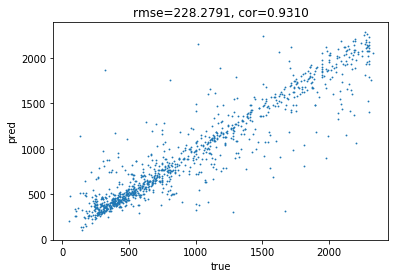

In [169]:
plt.scatter(species_ytest, species_ypred, s=0.7)
plt.xlabel('true')
plt.ylabel('pred')
plt.title('rmse={0:.4f}, cor={1:.4f}'.format(mean_squared_error(y_true=species_ytest, y_pred=species_ypred)**0.5,
                                     pearsonr(species_ytest, species_ypred)[0][0]))
plt.savefig(os.path.join(FLAG_model_save, 'scatter_per_species.png'))

In [170]:
result = pd.DataFrame({'Species':df_species_group.Species,
              'pred':species_ypred.reshape(-1),
              'true':species_ytest.reshape(-1)})

In [171]:
result.to_csv(os.path.join(FLAG_model_save, 'predictions_species.csv'), index=False)